In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
from statsmodels.stats.multitest import multipletests
import statsmodels.api as sm

In [2]:
# data files are exactly as received from MIRA Helsinki Study. This code does not write to these files.
data_lab = 'data/mira/HUSLAB Data final_WithMixedVegans.txt'
data_intakes = 'data/mira/muuttujat_analyysiin.txt'
data_thl = 'data/mira/growth-curves.tsv'
data_questionnaire = 'data/mira/data huoltajan tausta 171106.sav'
data_food_record = 'data/mira/radata.txt'

In [3]:
# animal proportion per food item collected for thesis, method and sources on page 39 of thesis
data_food_animal_proportion = 'data/food-animal-proportion.csv'

In [4]:
# global settings for graph output
scale=10
sns.set_theme(style='white',font_scale=2)

In [5]:
# clean output directory every time
import shutil
shutil.rmtree('out')

from pathlib import Path
Path('out').mkdir(parents=True, exist_ok=True)

In [6]:
#declare common column names as variables
ldl = 'fP-Kol-LDL (mmol/l)'
tc = 'fP-Kol (mmol/l)'
serum_lipids = [
    tc,
    ldl, 
    'fP-Kol-HDL (mmol/l)', 
    'fP-Trigly (mmol/l)'
]

In [7]:
# read in mira study data
lab_results = pd.read_csv(data_lab, sep='\t', decimal=",")
intakes = pd.read_csv(data_intakes, sep='\t')

df = lab_results.merge(intakes, on='ID')


# Only select subjects for whom we have an LDL lab result 
subjects = df[df[ldl].notna()]

In [8]:
# classify diets
g6_map = {
    'Pesco-vegetarian': 'Vegetarian',
    'Vegan': 'Vegan',
    'Control': 'Omnivore',
    'Control (vegan in daycare)': 'Omnivore',
    'Vegetarian': 'Vegetarian'
}
diet_class = 'diet classification'
diet_classes = ['Vegan','Vegetarian','Omnivore']

if not diet_class in subjects:
    subjects.insert(6,diet_class,subjects.Group4.map(g6_map))

# The aim of the Thesis and the research questions

**Figure 1.** The plasma LDL-C concentrations among the MIRA Helsinki Study participants

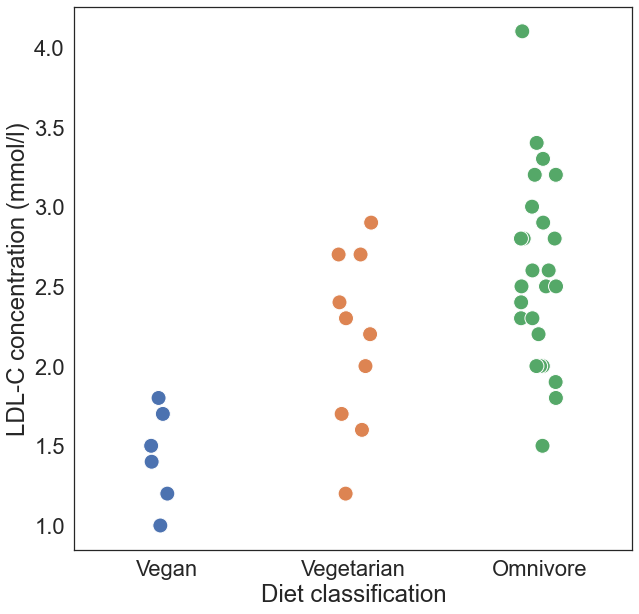

In [9]:
plt.close()
fig, ax = plt.subplots(figsize=(scale,scale))
ax = sns.stripplot(
    x=diet_class,
    order=diet_classes,
    y=ldl,
    data=subjects,
    s=15,
    linewidth=1,
    edgecolor="white"
)
ax.set_xlabel('Diet classification')
ax.set_ylabel('LDL-C concentration (mmol/l)')

plt.savefig('out/figure1-stripplot-diet-LDL.pdf')

# Methods
## Design and participants
**Figure 2**
The participant flow in the original MIRA Helsinki Study in 2017 and in the present thesis. Dietary classification done based on the food record and the FFQ data. Two participants originally omitted due to difficulties to classify are included in the present study as omnivores.

# Results

In [10]:
# Read in THL curves on finnish children

curves = pd.read_csv(data_thl,sep='\t',decimal=',')
curves.columns = [c.lower() for c in curves.columns]

# no curve for children under two, fill in with a linear extrapolation

def fill_start_with_linear_extrapolation(s):
    i = s.first_valid_index()
    x1 = s.loc[i]
    x2 = s.loc[2*i]
    x0 = x1 - (x2-x1)
    return pd.Series(np.linspace(x0,x1,i)).append(s[i:])


for c in 'bmi_mean_m','bmi_sd_m','bmi_nu_m','bmi_mean_f','bmi_sd_f','bmi_nu_f':
    s = curves[c]
    s2 = fill_start_with_linear_extrapolation(s)
    curves.insert(
        curves.columns.get_loc(c)+1,
        c+'_filled',
        s2
    )

# BMISDS = ((BMIlaskettu / muBMI) ^ nuBMI – 1) / (nuBMI × sigmaBMI)
def translate_sex(s):
    if s in ('M','m'): return 'm'
    if s in ('N','n','F','f'): return 'f'
    return None

def bmi_sds(weight,height,age,sex):
    age = round(age,2)
    sex = translate_sex(sex)

    bmi = weight/height**2
    
    row = curves[curves.age==age].iloc[0]
    mu_bmi = row['bmi_mean_'+sex+'_filled']
    nu_bmi = row['bmi_nu_'+sex+'_filled']
    sigma_bmi = row['bmi_sd_'+sex+'_filled']
    
    bmi_sds = ((bmi/mu_bmi)**nu_bmi - 1) / (nu_bmi * sigma_bmi)
    
    return bmi_sds

if not 'bmi_sds' in subjects:
    bmi_sds = subjects.apply(
        lambda row: bmi_sds(
            row.Weight,
            row.Height/100,
            row.Bage,
            row.Sex
        ),
        axis=1
    )
    subjects.insert(12,'bmi_sds',bmi_sds)
    
def is_female(s):
    return s in ('N','n','F','f')

def is_male(s):
    return s in ('M','m')

def classify_bmi_sds(bmi_sds,sex):
    if is_female(sex):
        if bmi_sds < -2.2187: return 'Significantly underweight'
        if bmi_sds < -1.6482: return 'Underweight'
        if bmi_sds > 2.7600: return 'Severely Obese'
        if bmi_sds > 2.1065: return 'Obese'
        if bmi_sds > 1.1629: return 'Overweight'
        return 'Normal'
    if is_male(sex):
        if bmi_sds < -2.3456: return 'Significantly underweight'
        if bmi_sds < -1.8344: return 'Underweight'
        if bmi_sds > 2.3600: return 'Severely Obese'
        if bmi_sds > 1.7016: return 'Obese'
        if bmi_sds > 0.7784: return 'Overweight'
        return 'Normal'
    return None

if not 'bmi_class' in subjects:
    bmi_class = subjects.apply(
        lambda row: classify_bmi_sds(
            row.bmi_sds,
            row.Sex
        ),
        axis=1
    )

    subjects.insert(13,'bmi_class',bmi_class)

## Characteristics of the study participants
**Table 1** The study participant characteristics. Values expressed as medians (range) if not otherwise informed.  ¹Age of the child at the time of the blood sampling. ²BMI Standard Deviation (SD) Score is calculated from the Finnish population growth data (113).  ³Classification of overweight/obese and underweight based on the Finnish BMI-for-age percentile curves (113).

In [11]:
df = subjects.groupby('Sex').count()[['ID']]
df.to_csv('out/table1-sex.csv')
df

,ID
Sex,
M,21
N,21


In [12]:
df = subjects[['Bage','bmi_sds']+serum_lipids].describe().round(2)
df.to_csv('out/table1-age-bmi-serumlipids.csv')
df

,Bage,bmi_sds,fP-Kol (mmol/l),fP-Kol-LDL (mmol/l),fP-Kol-HDL (mmol/l),fP-Trigly (mmol/l)
count,42.00,42.00,42.00,42.00,42.00,42.00
mean,4.02,0.35,3.86,2.34,1.41,0.61
std,1.56,1.11,0.73,0.68,0.24,0.13
min,1.61,-2.55,2.40,1.00,0.93,0.32
25%,2.79,-0.17,3.30,1.82,1.24,0.51
50%,3.52,0.41,3.80,2.35,1.40,0.61
75%,5.18,0.96,4.50,2.80,1.59,0.68
max,7.17,3.04,5.60,4.10,1.92,0.86


In [13]:
df = subjects.groupby('bmi_class').count()[['ID']]
df.to_csv('out/table1-bmi_class.csv')
df

,ID
bmi_class,
Normal,30
Obese,1
Overweight,9
Severely Obese,1
Significantly underweight,1


**Table 2** The highest level of maternal education, expressed as either ongoing or completed studies. +lisää prosentit?

In [14]:
def mothers_education(row):
    if row.v37=='1': return 0
    if row.v38=='1': return 1
    if row.v39=='1': return 2
    if row.v40=='1': return 3
    if row.v41=='1': return 4
    if row.v42=='1': return 5
    if row.v43=='1': return 6
    return None

def subject_mothers_education():
    df = pd.read_spss(
        data_questionnaire,
        usecols=['ID', 'v37', 'v38', 'v39', 'v40', 'v41', 'v42', 'v43']
    ).set_index('ID')
    for i,row in df.iterrows():
        df.at[i,'education_mother'] = mothers_education(row)
    return df[['education_mother']]

if not 'education_mother' in subjects:
    subjects = subjects.merge(
        subject_mothers_education(), 
        on='ID', 
        how='left'
    )
    
df = subjects.groupby('education_mother',dropna=False).count()[['ID']]
df.columns = ['num']
df['percent'] = df.num / df.num.sum() * 100.0
df = df.round(2)
df.to_csv('out/table2-education_mother.csv')
df

,num,percent
education_mother,,
1.0,3,7.14
2.0,1,2.38
3.0,11,26.19
4.0,22,52.38
5.0,2,4.76
NaN,3,7.14


**Table 5.** The participants’ dietary intakes.

In [15]:
subjects['ENER_kcal_per_d'] = subjects.ENERJ_per_d / 4.184

intake_e_pros = [
    'FAT_e_pros', 
    'FASAT_e_pros',
    'FAMS_e_pros',
    'FAPU_e_pros',
    'CHOL_per_MJ',
    'PROT_e_pros',
    'CHO_e_pros',
    'SUCS_e_pros',
    'FIBC_per_MJ',
    'SALT_per_MJ',
]
intake_per_d = [
    'ENERJ_per_d',
    'ENER_kcal_per_d',
    'FAT_e_pros', 
    'FASAT_e_pros',
    'FAMS_e_pros',
    'FAPU_e_pros',
    'CHOL_per_MJ',
    'PROT_e_pros',
    'CHO_e_pros',
    'SUCS_e_pros',
    'FIBC_per_MJ',
    'SALT_per_MJ',    
]
df = subjects[intake_e_pros+intake_per_d].describe().round(2)
df.to_csv('out/table3-intakes.csv')
df

,FAT_e_pros,FASAT_e_pros,FAMS_e_pros,FAPU_e_pros,CHOL_per_MJ,PROT_e_pros,CHO_e_pros,SUCS_e_pros,FIBC_per_MJ,SALT_per_MJ,...,FAT_e_pros,FASAT_e_pros,FAMS_e_pros,FAPU_e_pros,CHOL_per_MJ,PROT_e_pros,CHO_e_pros,SUCS_e_pros,FIBC_per_MJ,SALT_per_MJ
count,42.00,42.00,42.00,42.00,42.00,42.00,42.00,42.00,42.00,42.00,...,42.00,42.00,42.00,42.00,42.00,42.00,42.00,42.00,42.00,42.00
mean,32.60,10.40,11.36,6.75,19.76,15.29,48.56,10.15,3.65,0.76,...,32.60,10.40,11.36,6.75,19.76,15.29,48.56,10.15,3.65,0.76
std,4.49,3.59,1.85,2.69,14.99,2.41,4.84,3.57,1.23,0.11,...,4.49,3.59,1.85,2.69,14.99,2.41,4.84,3.57,1.23,0.11
min,19.27,4.21,6.37,3.00,0.10,10.13,41.32,3.86,1.69,0.58,...,19.27,4.21,6.37,3.00,0.10,10.13,41.32,3.86,1.69,0.58
25%,30.11,7.19,10.02,4.74,7.56,13.73,45.21,8.18,2.61,0.69,...,30.11,7.19,10.02,4.74,7.56,13.73,45.21,8.18,2.61,0.69
50%,33.15,10.96,11.26,6.08,18.75,15.23,47.79,9.01,3.39,0.74,...,33.15,10.96,11.26,6.08,18.75,15.23,47.79,9.01,3.39,0.74
75%,35.54,12.40,12.60,8.73,26.95,16.61,49.98,11.47,4.68,0.84,...,35.54,12.40,12.60,8.73,26.95,16.61,49.98,11.47,4.68,0.84
max,41.80,17.92,15.20,12.39,67.32,21.30,64.99,18.21,6.18,1.09,...,41.80,17.92,15.20,12.39,67.32,21.30,64.99,18.21,6.18,1.09


## Food item scoring

In [16]:
food_records = pd.read_csv(
    data_food_record, 
    sep='\t', 
    encoding='iso-8859-1')

food_animal_percent = pd.read_csv(
    data_food_animal_proportion, 
    index_col='code'
).drop(columns=['link'])

food_records = food_records.merge(
    food_animal_percent, 
    left_on='Code', 
    right_on='code', 
    how='left'
)
food_records['timestamp'] = pd.to_datetime(
    food_records.DaDate + ' ' + food_records.MaTime,
    format='%d.%m.%Y %H:%M:%S'
)

<AxesSubplot:>

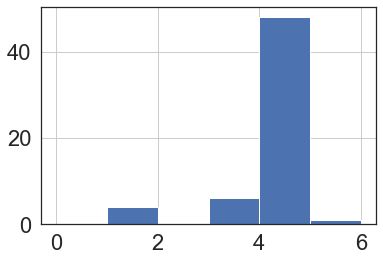

In [17]:
#sanity checking food record lenths
df = food_records.groupby('ID').agg({'timestamp': ['min', 'max']})
df.columns = ['ts_min','ts_max']
df = df.merge(
    food_records[['ID','DaDate']].groupby('ID').nunique(),
    on='ID'
)
df.rename(columns = {'DaDate':'record_distinct_dates'}, inplace = True)
df.to_csv('out/record_lengths.csv')
df.record_distinct_dates.hist(range=(0,6),bins=6)

In [18]:
# sanity check which food items with nonzero animal content appear for vegans

df = food_records.merge(
    subjects[['ID','Group4']], 
    on='ID', 
    how='left')
df = df[
    (df.animal_proportion > 0) 
    & (df.Group4 == 'Vegan')
]
df.groupby(['name','MaName']).count()['Group4']

name                                   MaName
Knorr Kalaliemi, jauhe, vähäsuolainen  L_pk      7
Ruoanvalmistusrasva keskiarvo          P_k       2
Name: Group4, dtype: int64

**Table 4.** Number of food items within the deciles according to the proportion of animal origin content.

In [19]:
df = food_animal_percent.groupby('animal_decile').count()
df.to_csv('out/table4-food_items_per_animal_decile.csv')
df

,name,animal_proportion
animal_decile,,
0.0,489,489
0.1,18,18
0.2,7,7
0.3,5,5
0.4,4,4
0.5,9,9
0.6,5,5
0.7,10,10
0.8,5,5


## ASE intakes among the dietary categories

**Figure 3.** Distribution of the ASE proportions by the diet classification (grouping based on the food records and background questionnaires). Participants' dietary classification is indicated with color coding, with blue for vegan, orange for vegetarian and green for omnivore group.The vegetarian group included lactovegetarians, lacto-ovo-vegetarians and pescovegetarians.

In [20]:
# calculate ASE proportion
r_animal = 'r_animal_source_energy'
r_animal_label = 'Animal source energy proportion'

e = food_records[['ID','ENERJ','animal_proportion']]
e = e.assign(ENERJ_animal=(e.ENERJ * e.animal_proportion)).drop(columns=['animal_proportion'])

#energy per subject
eps = e.groupby(['ID']).sum()
eps = eps.assign(r_animal_source_energy=(eps.ENERJ_animal / eps.ENERJ))

if not r_animal in subjects:
    subjects = subjects.merge(eps, on='ID')

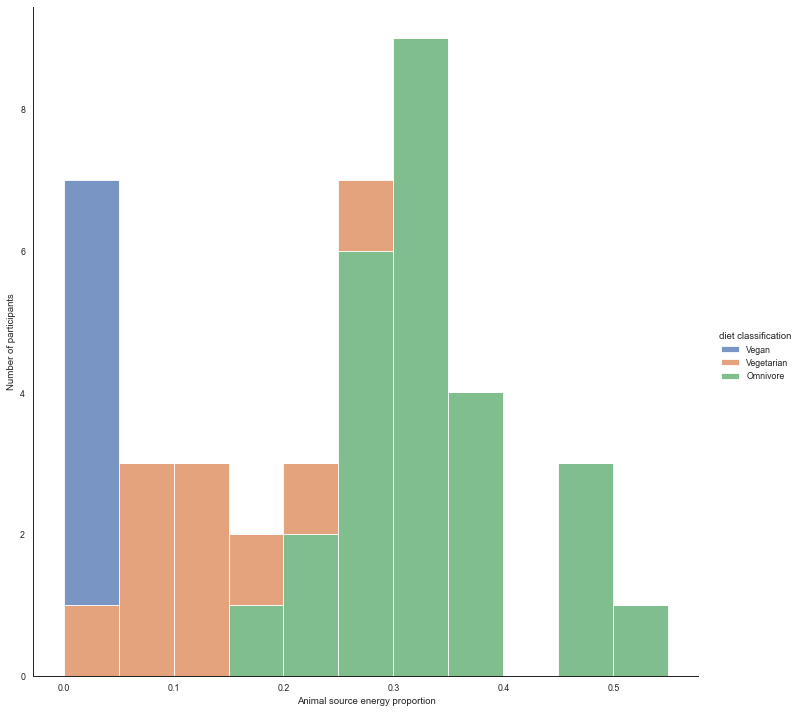

In [21]:
sns.set_context("paper")

plt.close()
fg = sns.displot(
    subjects,
    x=r_animal,
    binwidth=0.05,
    hue=diet_class,
    hue_order=diet_classes,
    multiple='stack',
    height=scale)
fg.axes[0,0].set_xlabel(r_animal_label)
fg.axes[0,0].set_ylabel('Number of participants')
plt.savefig('out/figure3-ASE-histogram.pdf')

## Animal ratio and dietary intakes
Table 4
Pearson correlation coefficients for correlations between ASE proportion and dietary intakes. *Significance of the p-value corrected for multiple analyses using the Benjamini-Hochberg procedure, FDR 0.05.

In [22]:

def correlation_values(xs,ys):
    table = []
    for x in xs:
        for y in ys:
            df = subjects[[x,y]].dropna()
            pr, pp = pearsonr(df[x],df[y])
            table.append([x,y,pr,pp])

    df = pd.DataFrame(table,columns=['x','y','pearson_r','pearson_p'])
    df['fdr_bh_0_05'] = multipletests(df['pearson_p'], alpha=0.05, method='fdr_bh')[0]
    df = df.sort_values(by='pearson_p')
    df = df.round(3)
    return df

In [23]:
df = correlation_values([r_animal],intake_e_pros)
df.to_csv('out/table5-correlations-ASE-intake_e_pros.csv')
df

,x,y,pearson_r,pearson_p,fdr_bh_0_05
8,r_animal_source_energy,FIBC_per_MJ,-0.836,0.000,True
1,r_animal_source_energy,FASAT_e_pros,0.815,0.000,True
3,r_animal_source_energy,FAPU_e_pros,-0.815,0.000,True
4,r_animal_source_energy,CHOL_per_MJ,0.707,0.000,True
5,r_animal_source_energy,PROT_e_pros,0.493,0.001,True
2,r_animal_source_energy,FAMS_e_pros,-0.283,0.069,False
7,r_animal_source_energy,SUCS_e_pros,-0.220,0.161,False
9,r_animal_source_energy,SALT_per_MJ,0.203,0.196,False
6,r_animal_source_energy,CHO_e_pros,-0.201,0.202,False
0,r_animal_source_energy,FAT_e_pros,0.077,0.628,False


In [24]:
df = correlation_values([r_animal],intake_per_d)
df.to_csv('out/table5-correlations-ASE-intake_per_d.csv')
df

,x,y,pearson_r,pearson_p,fdr_bh_0_05
10,r_animal_source_energy,FIBC_per_MJ,-0.836,0.000,True
3,r_animal_source_energy,FASAT_e_pros,0.815,0.000,True
5,r_animal_source_energy,FAPU_e_pros,-0.815,0.000,True
6,r_animal_source_energy,CHOL_per_MJ,0.707,0.000,True
7,r_animal_source_energy,PROT_e_pros,0.493,0.001,True
4,r_animal_source_energy,FAMS_e_pros,-0.283,0.069,False
9,r_animal_source_energy,SUCS_e_pros,-0.220,0.161,False
11,r_animal_source_energy,SALT_per_MJ,0.203,0.196,False
8,r_animal_source_energy,CHO_e_pros,-0.201,0.202,False
1,r_animal_source_energy,ENER_kcal_per_d,-0.185,0.242,False


In [25]:
from string import ascii_lowercase

# solution to rasterize only the confidence intervals https://stackoverflow.com/questions/44303349/non-transparent-confidence-intervals-in-seaborn

def regplot_r_animal(ax,y,y_label):
    ax.set_xlim(-0.01, subjects.r_animal_source_energy.max()+0.01)
    sns.regplot(ax=ax, x=r_animal, y=y, scatter=False, data=subjects)
    sns.scatterplot(
        ax=ax, 
        x=r_animal, 
        y=y, 
        hue=diet_class, 
        hue_order=diet_classes, 
        data=subjects, 
        s=30*scale,
        legend=False
    )
    ax.set_xlabel(r_animal_label)
    ax.set_ylabel(y_label)


def fig_of_regplots(ys,cols=2):

    plt.close()
    sns.set_theme(style='white',font_scale=2)
    
    rows = int(len(ys)/cols)+(len(ys)%cols > 0)
    h = rows*scale
    if rows > 1: h+=2
    w = cols*scale+2
    


    fig, axs = plt.subplots(rows,cols,figsize=(w,h))
        
    if rows > 1:
        axs_flat = [ax for row in axs for ax in row]
    else:
        axs_flat = axs

    l = list(zip(ys.keys(),ys.values(),axs_flat))
    i = 0
    for t in l:
        regplot_r_animal(t[2],t[0],t[1])
        t[2].set_title(
            ascii_lowercase[i]+')',
            loc='left',
            fontdict={
#                'fontweight': 'bold',
                'verticalalignment': 'bottom'
            }
        )
        i+=1

    for ax in axs_flat[len(ys):]:
        fig.delaxes(ax)
        
    return fig, axs

**Figure 4.** Scatter plots showing the statistically significant correlations between the ASE proportion and dietary intakes of a) SAFA (E%), b) PUFA (E%) and c) cholesterol (mg per MJ/d). Participants' dietary classification is indicated with color coding, with blue for vegan, orange for vegetarian and green for omnivore group. The shaded light blue area represents the 95% confidence interval for the regression. In panel a), the dashed red line represents the dietary recommendation for children in Finland (120)(120), which for SAFA intake is <10E%. Correspondingly, in panel b), the dashed red line represents the lower reference intake for PUFA in the childrens’ recommendations (>5 E%) (120)(120). In panel c), the participants with an ASE proportion of 0 (n=7) are piled up on top of each other. 

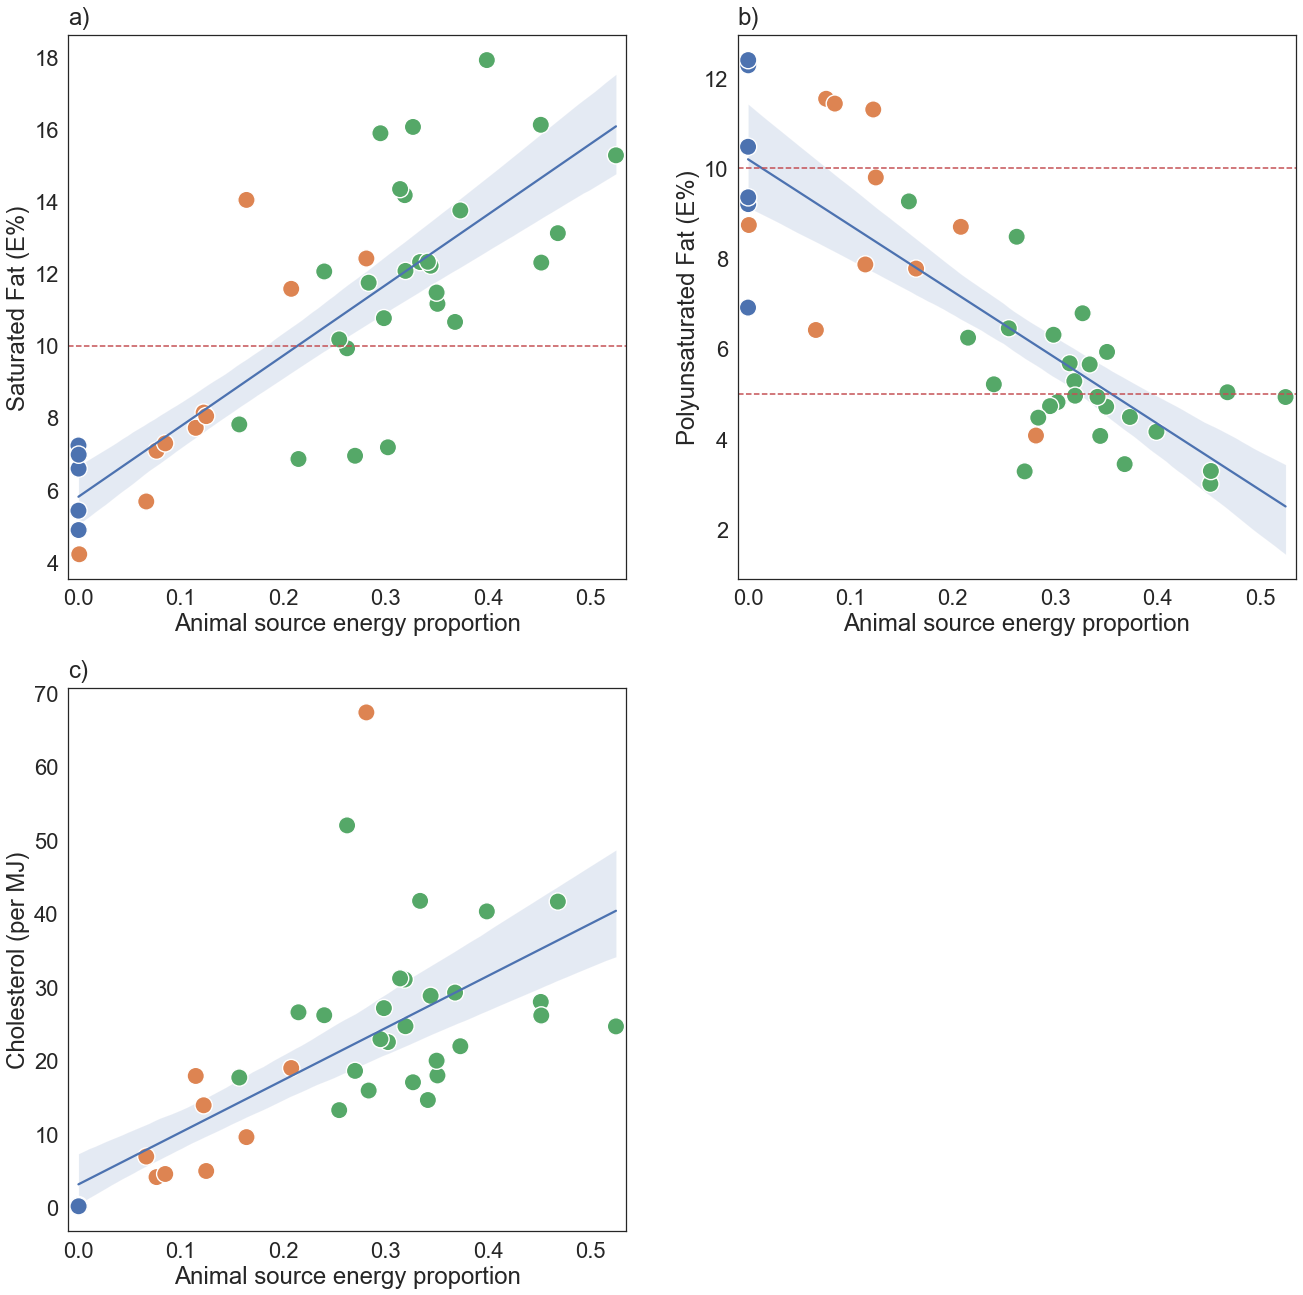

In [26]:
sns.set_context("paper")

ys = {
    'FASAT_e_pros': 'Saturated Fat (E%)',
    'FAPU_e_pros': 'Polyunsaturated Fat (E%)',
    'CHOL_per_MJ': 'Cholesterol (per MJ)',
}

fig, axs = fig_of_regplots(ys)

axs[0][0].axhline(10,ls='--',color='r') #FASAT high

axs[0][1].axhline(5,ls='--',color='r') # FAPU low
axs[0][1].axhline(10,ls='--',color='r') # FAPU high


plt.savefig('out/figure4-scatter-ASE-SAFA-PUFA-TC.pdf')

plt.show()

**Figure 5.** Scatter plots of the correlations between the ASE proportion and dietary intakes of a) fibre (g per MJ) and b) protein (E%). Diet groups and 95% confidence intervals indicated as in Figure 4. In panel a), the recommended fibre intake (2–3 g/MJ) for over 2-year old children in Finland (120)(120) is indicated with dashed red lines. Similarly, in panel b) the dietary recommendation for protein intake (10–20 E%) for children (120)(120) is displayed with dashed red lines. 

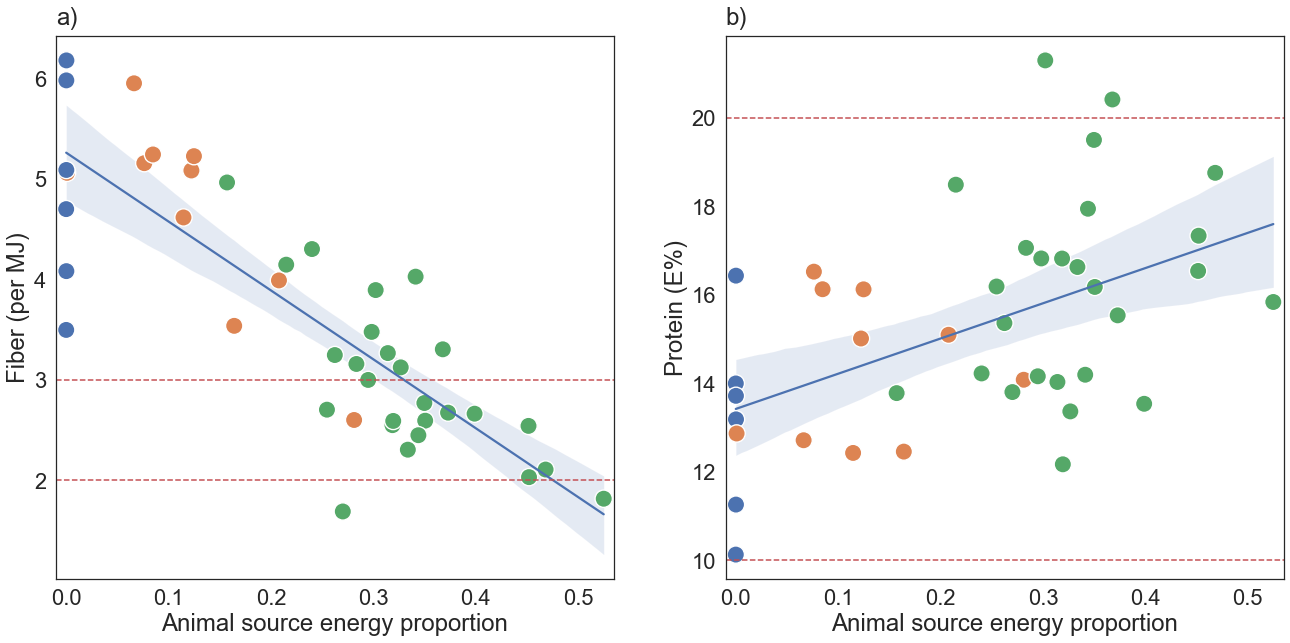

In [27]:
ys = {
    'FIBC_per_MJ': 'Fiber (per MJ)',
    'PROT_e_pros': 'Protein (E%)',
}

fig, axs = fig_of_regplots(ys)

axs[0].axhline(2,ls='--',color='r') # FIBC low
axs[0].axhline(3,ls='--',color='r') # FIBC high

axs[1].axhline(10,ls='--',color='r') #prot low
axs[1].axhline(20,ls='--',color='r') #prot high

plt.savefig('out/figure5-scatter-ASE-FIBC-PROT.pdf')

plt.show()

**Table 6.** Correlations between ASE proportion and plasma lipid concentrations

In [28]:
df = correlation_values([r_animal],serum_lipids)
df.to_csv('out/table6-correlations-ASE-serum_lipids.csv')
df

,x,y,pearson_r,pearson_p,fdr_bh_0_05
1,r_animal_source_energy,fP-Kol-LDL (mmol/l),0.707,0.000,True
0,r_animal_source_energy,fP-Kol (mmol/l),0.668,0.000,True
2,r_animal_source_energy,fP-Kol-HDL (mmol/l),0.306,0.048,False
3,r_animal_source_energy,fP-Trigly (mmol/l),-0.128,0.420,False


**Figure 6**. The scatter plots of ASE proportion and plasma concentrations (mmol/l) of a) total cholesterol, b) LDL-cholesterol, c) HDL-cholesterol and c) triglycerides. Diet groups and 95% confidence intervals indicated as in Figure 4. In panel a), some participants with an ASE proportion of 0 are piled up on top of each. In panel c), the red dashed line represents the high cut-off for LDL-C concentration for abnormal childhood lipid levels in previous literature for Finnish children ≤ 9 years (48)(48).

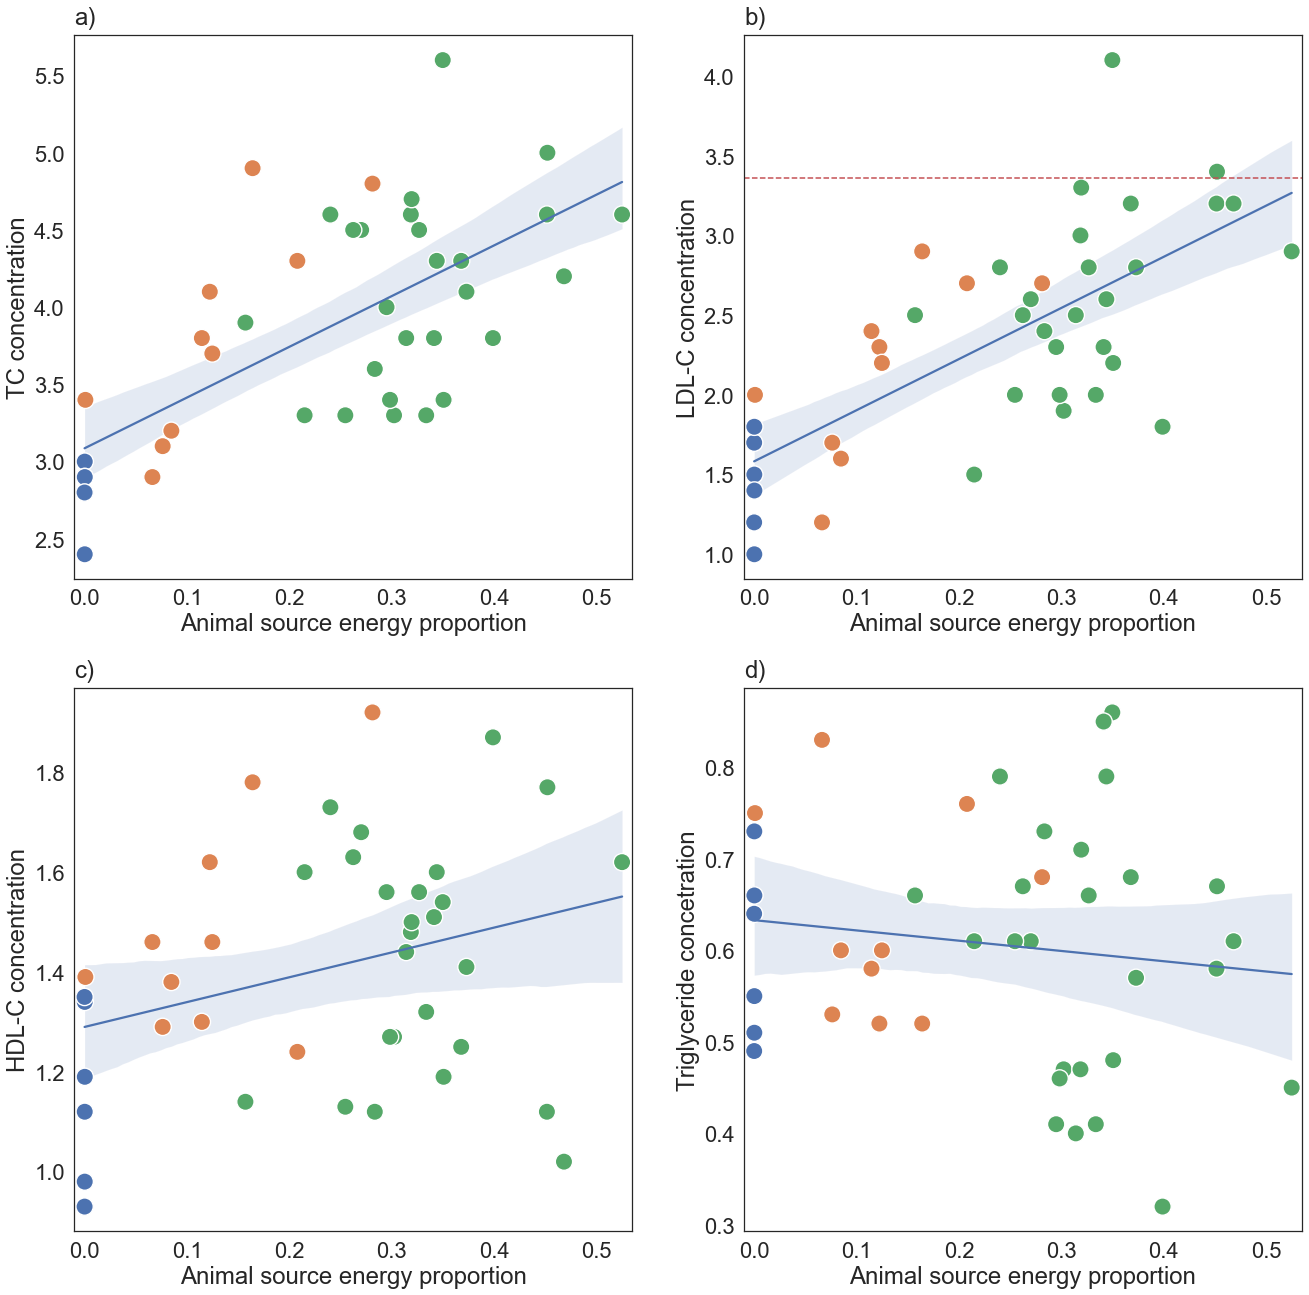

In [29]:
serum_lipid_labels=['TC concentration','LDL-C concentration','HDL-C concentration','Triglyceride concetration']

fig, axs = fig_of_regplots(dict(zip(serum_lipids,serum_lipid_labels)))

axs[0][1].axhline(3.36,ls='--',color='r') # limit for children

plt.savefig('out/figure6-scatter-ASE-serum_lipids.pdf')

plt.show()

## Multiple regression model to explain plasma LDL-C concentration


In [30]:
def ols_result(xs,ys):
    df = subjects[xs+ys].dropna()
    
    X = df[xs]
    Y = df[ys]
    
    X = sm.add_constant(X)
    
    return sm.OLS(Y, X).fit()

## Animal source energy proportion as a predictor of plasma LDL-cholesterol

**Table 7.** The multiple linear regression model to explane plasma LDL-cholesterol concentration (mmol/l) with ASE proportion, child’s sex and maternal education. 

In [31]:
subjects.loc[subjects.Sex == 'N', 'sex_dummy'] = 0
subjects.loc[subjects.Sex == 'M', 'sex_dummy'] = 1

summary = ols_result([r_animal,'sex_dummy','education_mother'],[ldl]).summary()

file = open('out/table7-OLS-ASE_sex_education-LDL.html', 'w')
file.write(summary.as_html())
file.close()
summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     fP-Kol-LDL (mmol/l)   R-squared:                       0.486
Model:                             OLS   Adj. R-squared:                  0.442
Method:                  Least Squares   F-statistic:                     11.04
Date:                 Tue, 06 Jul 2021   Prob (F-statistic):           2.99e-05
Time:                         00:10:59   Log-Likelihood:                -26.436
No. Observations:                   39   AIC:                             60.87
Df Residuals:                       35   BIC:                             67.53
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      1.4960      0.427      3.508      0.001       0.630       2.362
r_animal_source_energy     3.2467      0.591      5.493      0.000       2.047       4.447
sex_dummy                  0.0425      0.170      0.250      0.804      -0.303       0.388
education_mother           0.0244      0.092      0.265      0.792      -0.162       0.211
==============================================================================
Omnibus:                        0.688   Durbin-Watson:                   2.060
Prob(Omnibus):                  0.709   Jarque-Bera (JB):                0.173
Skew:                           0.131   Prob(JB):                        0.917
Kurtosis:                       3.195   Cond. No.                         31.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Biomarkers of cholesterol metabolism and bile acid synthesis

In [32]:
chol_absorption_markers = [
    'Cholestanol',
    'Campesterol',
    'Sitosterol',
    'Avenasterol',
]
chol_synthesis_markers = [
    'Cholestenol',
    'Desmosterol',
    'Lathosterol',
    'Squalene',
]
subjects['r_campesterol_to_cholestanol'] = subjects.Campesterol / subjects.Cholestanol

**Table 8.** Serum surrogate markers of cholesterol absorption and synthesis, and bile acid synthesis biomarker 7α-OH-4-cholesten-3-one among the study participants. Values expressed as median (range).

In [33]:
df = subjects[
    chol_absorption_markers
    +chol_synthesis_markers
    +['7-OH-4-cholesten-3-one','r_campesterol_to_cholestanol']
    +serum_lipids
].describe()
df.to_csv('out/table8-chol_markers.csv')
df

,Cholestanol,Campesterol,Sitosterol,Avenasterol,Cholestenol,Desmosterol,Lathosterol,Squalene,7-OH-4-cholesten-3-one,r_campesterol_to_cholestanol,fP-Kol (mmol/l),fP-Kol-LDL (mmol/l),fP-Kol-HDL (mmol/l),fP-Trigly (mmol/l)
count,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000
mean,172.858888,370.904714,200.395701,56.890521,14.964564,92.732707,92.519558,8.046701,0.053393,2.110383,3.857143,2.335714,1.406667,0.606667
std,22.909599,126.221259,68.707637,19.345325,6.511644,11.213191,42.911070,3.262927,0.073605,0.530701,0.734894,0.678528,0.242876,0.131198
min,117.757420,132.703340,103.544310,25.281254,8.541776,72.931027,42.721618,2.861026,0.009600,0.838346,2.400000,1.000000,0.930000,0.320000
25%,158.347749,272.536657,144.363782,41.110928,10.883834,84.449287,68.452531,6.190620,0.017900,1.754335,3.300000,1.825000,1.242500,0.512500
50%,170.740747,369.296609,185.511576,55.440401,13.519894,91.622202,84.811222,7.274772,0.028850,2.102937,3.800000,2.350000,1.400000,0.610000
75%,190.067175,445.284856,241.135488,65.692506,16.092879,98.379944,105.139464,9.241557,0.064975,2.441951,4.500000,2.800000,1.590000,0.680000
max,214.398556,671.580672,336.960337,100.706519,46.419411,129.816997,287.957703,18.165987,0.461700,3.298851,5.600000,4.100000,1.920000,0.860000


**Table 9.** The Pearson correlation coefficients between animal source energy and plasma cholesterol absorption and synthesis biomarkers and the plasma bile acid synthesis biomarker (7α-OH-4-cholesten-3-one). The cholesterol synthesis and absorption markers expressed as their ratios to plasma TC concentrations. 

In [34]:

df = correlation_values(
    [r_animal],
    chol_absorption_markers+chol_synthesis_markers+['7-OH-4-cholesten-3-one','r_campesterol_to_cholestanol']+serum_lipids)
df.to_csv('out/table9-correlations-ASE-cholesterol_markers.csv')
df

,x,y,pearson_r,pearson_p,fdr_bh_0_05
11,r_animal_source_energy,fP-Kol-LDL (mmol/l),0.707,0.000,True
10,r_animal_source_energy,fP-Kol (mmol/l),0.668,0.000,True
2,r_animal_source_energy,Sitosterol,-0.561,0.000,True
3,r_animal_source_energy,Avenasterol,-0.542,0.000,True
1,r_animal_source_energy,Campesterol,-0.440,0.004,True
4,r_animal_source_energy,Cholestenol,-0.420,0.006,True
0,r_animal_source_energy,Cholestanol,-0.417,0.006,True
9,r_animal_source_energy,r_campesterol_to_cholestanol,-0.374,0.015,True
8,r_animal_source_energy,7-OH-4-cholesten-3-one,-0.371,0.015,True
6,r_animal_source_energy,Lathosterol,-0.337,0.029,True


**Figure 7**. Correlations between ASE proportion and the serum biomarkers of cholesterol absorption, a) cholestanol, b) campesterol, c) sitosterol and d) avenasterol, expressed as their ratios to total cholesterol (100 x μg/mg).

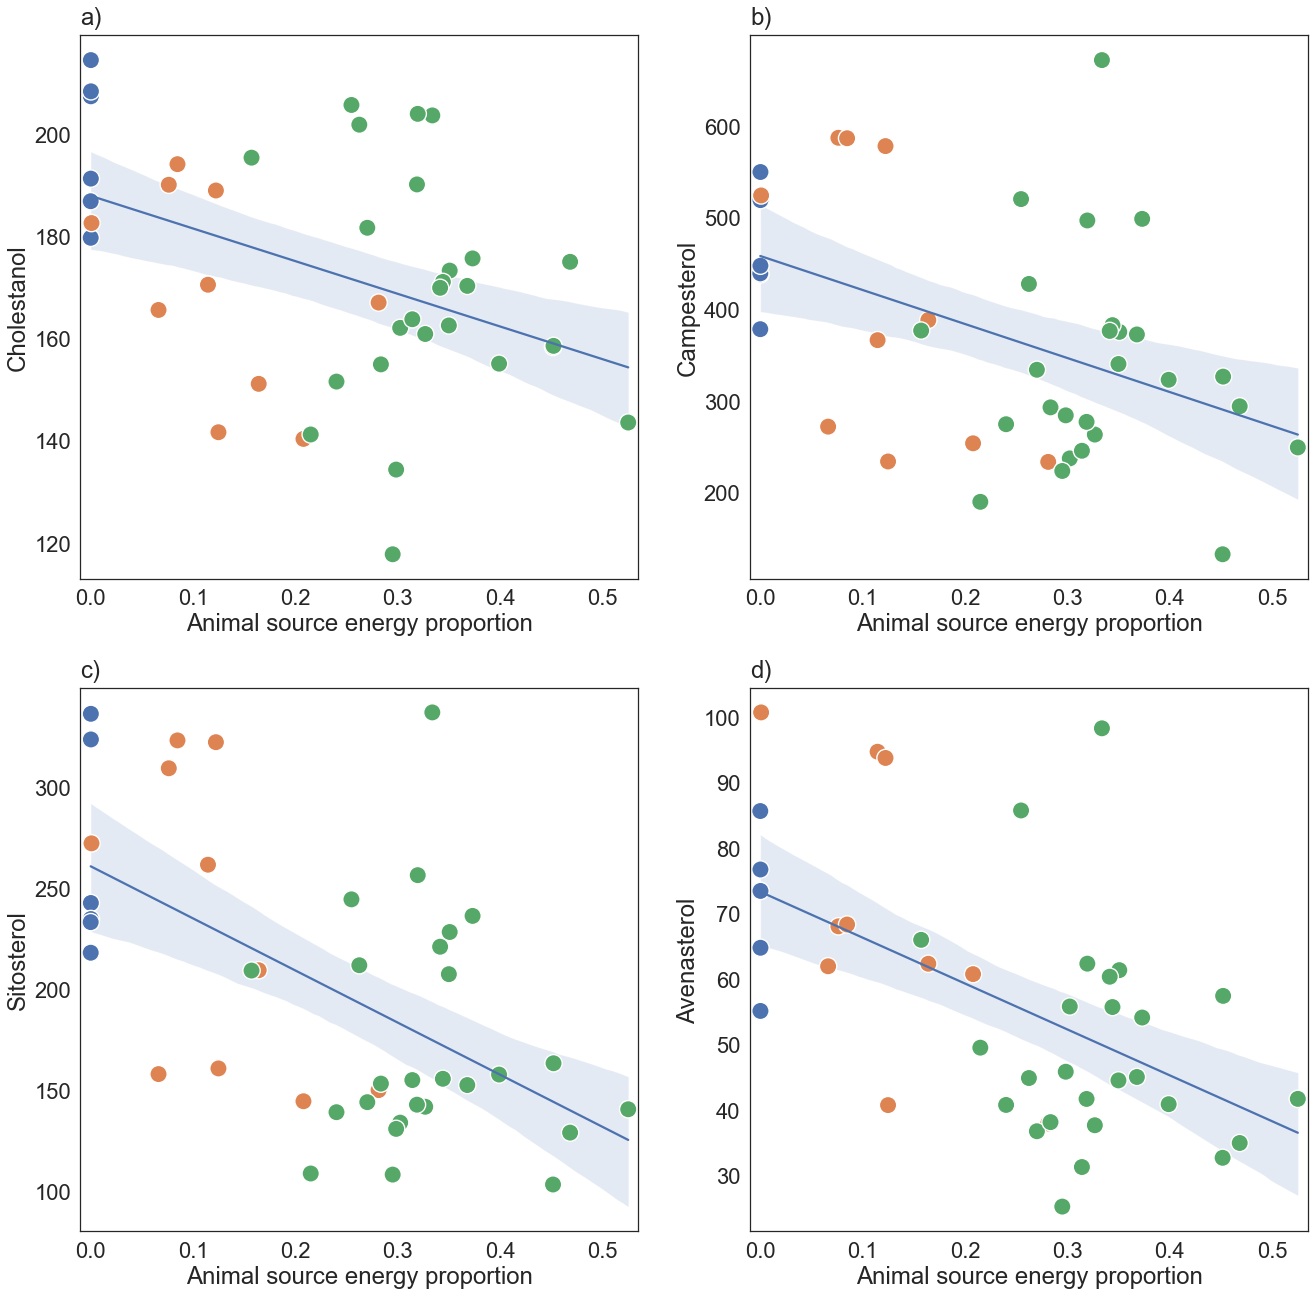

In [35]:
ys = dict(zip(chol_absorption_markers,chol_absorption_markers))

fig, axs = fig_of_regplots(ys)

plt.savefig('out/figure7-scatter-ASE-chol_absorption_markers.pdf')

plt.show()

**Figure 8.** Correlations between ASE proportion and the serum biomarkers of cholesterol synthesis, a) cholestenol, b) desmosterol, c) lathosterol and d) squalene, expressed as their ratios to total cholesterol (100 x μg/mg).

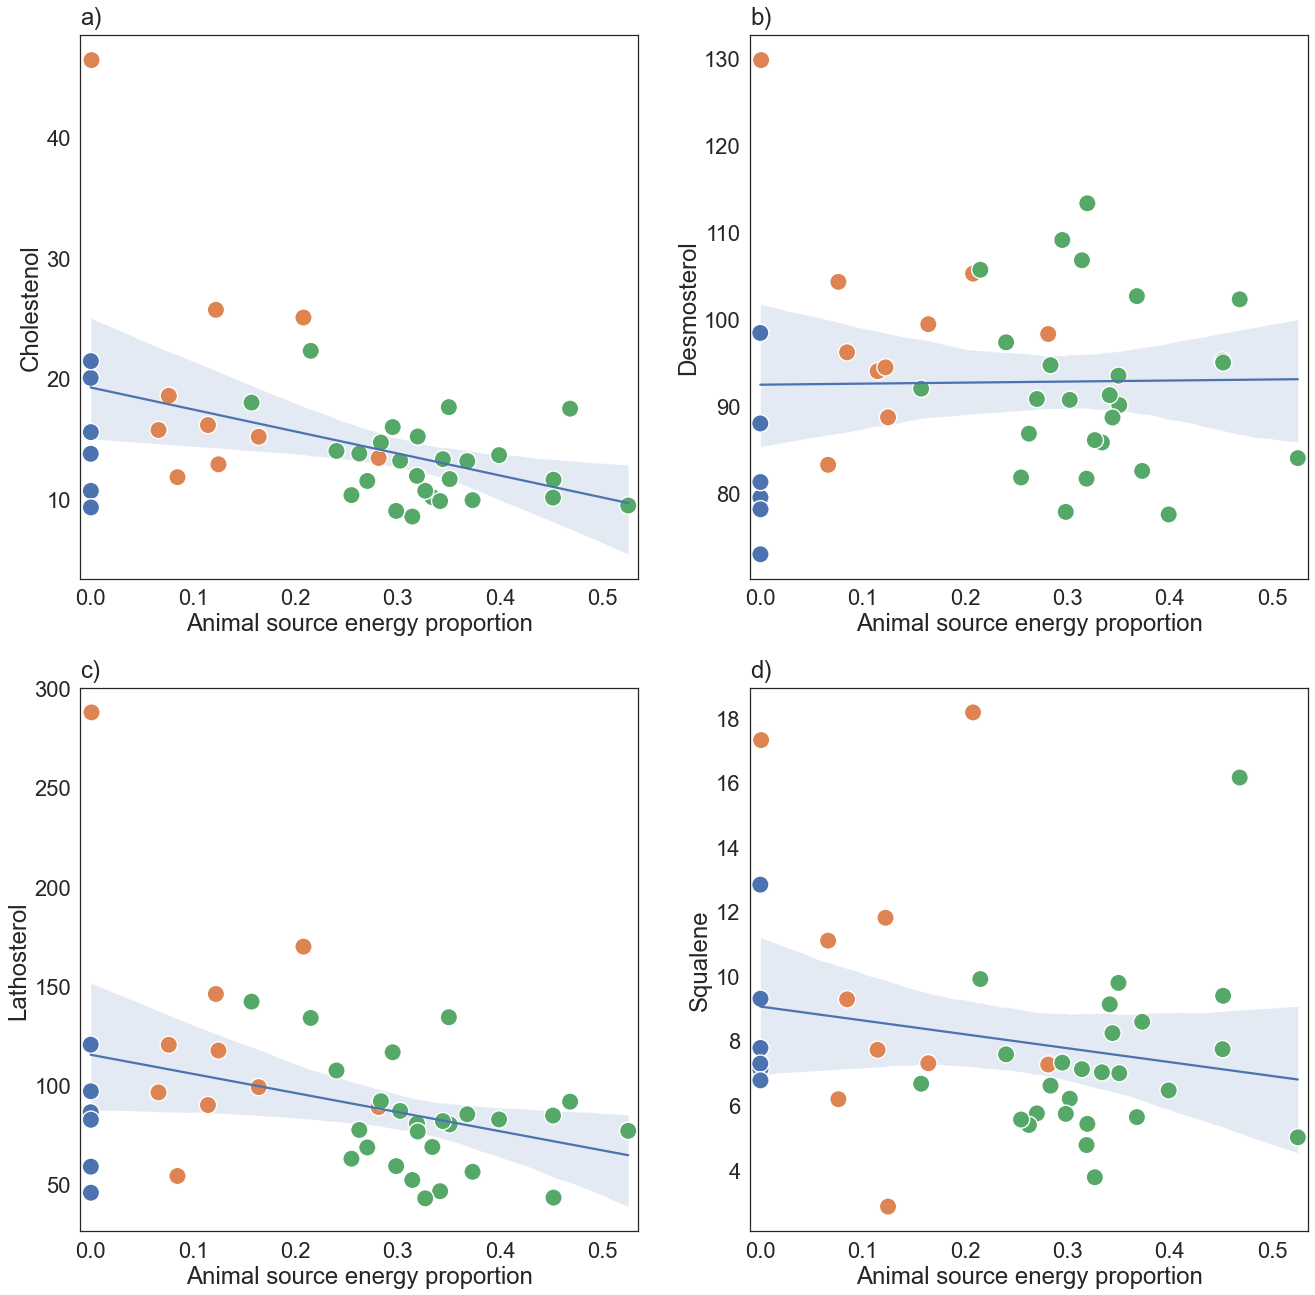

In [36]:
ys = dict(zip(chol_synthesis_markers,chol_synthesis_markers))

fig, axs = fig_of_regplots(ys)

plt.savefig('out/figure8-scatter-ASE-chol_synthesis_markers.pdf')

plt.show()

**Figure 9.** Correlation of ASE proportion and serum concentration of bile acid synthesis marker 7α-OH-4-cholesten-3-one (μmol/l).

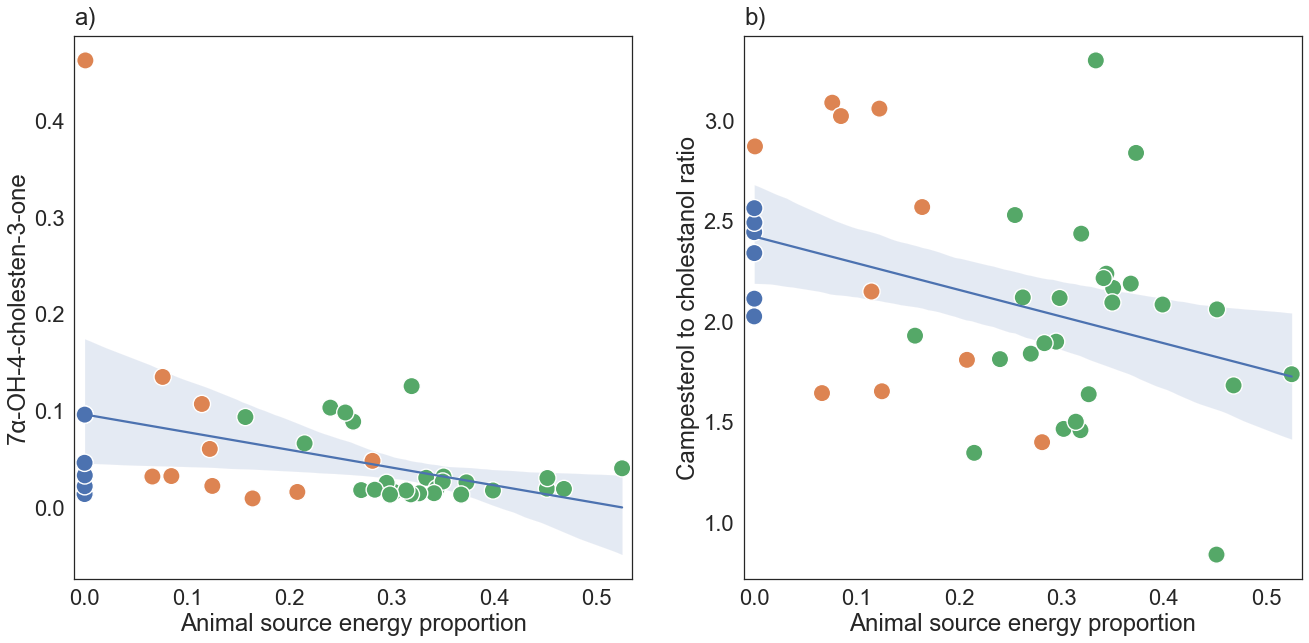

In [37]:
ys = {
    '7-OH-4-cholesten-3-one':'7α-OH-4-cholesten-3-one',
    'r_campesterol_to_cholestanol':'Campesterol to cholestanol ratio'
}

fig, axs = fig_of_regplots(ys)

plt.savefig('out/figure9-scatter-ASE-bile_acid_synthesis_marker-plant_sterol_intake.svg')

plt.show()

## Bile acid composition

In [38]:
glycine_conjugated_bile_acids = ['GCDCA','GCA','GLCA','GUDCA','GDCA']
taurine_conjugated_bile_acids = ['TUDCA','TCA','TDCA','TLCA','TCDCA']
unconjugated_bile_acids = ['UDCA','HDCA','CDCA','DCA','LCA','CA']
all_bile_acids = unconjugated_bile_acids + glycine_conjugated_bile_acids + taurine_conjugated_bile_acids

subjects = subjects.assign(
    total_bile_acids=subjects[all_bile_acids].sum(axis=1))
subjects = subjects.assign(
    total_glycine_conjugated_bile_acids = subjects[glycine_conjugated_bile_acids].sum(axis=1))
subjects = subjects.assign(
    total_taurine_conjugated_bile_acids = subjects[taurine_conjugated_bile_acids].sum(axis=1))
subjects = subjects.assign(
    conjugated_bile_acid_ratio = (
        subjects.total_taurine_conjugated_bile_acids / subjects.total_glycine_conjugated_bile_acids))

bile_acid_group_totals = [
    'total_bile_acids',
    'total_glycine_conjugated_bile_acids', 
    'total_taurine_conjugated_bile_acids',
    'conjugated_bile_acid_ratio'
]


**Table 10.** Pearson correlation coefficients between animal source energy intake and the plasma bile acid variables. Significance given after correcting for multiple analysis with the Benjamini-Hochberg procedure, FDR 0.05.

In [39]:
df = correlation_values(
    [r_animal],
    all_bile_acids+bile_acid_group_totals
)
df.to_csv('out/table10-correlations-ASE-bile_acids.csv')
df

,x,y,pearson_r,pearson_p,fdr_bh_0_05
19,r_animal_source_energy,conjugated_bile_acid_ratio,0.531,0.000,True
2,r_animal_source_energy,CDCA,-0.410,0.007,False
16,r_animal_source_energy,total_bile_acids,-0.381,0.013,False
7,r_animal_source_energy,GCA,-0.320,0.039,False
17,r_animal_source_energy,total_glycine_conjugated_bile_acids,-0.303,0.051,False
6,r_animal_source_energy,GCDCA,-0.300,0.053,False
10,r_animal_source_energy,GDCA,-0.291,0.061,False
5,r_animal_source_energy,CA,-0.235,0.135,False
0,r_animal_source_energy,UDCA,-0.230,0.143,False
3,r_animal_source_energy,DCA,-0.197,0.211,False


# Supplements